In [1]:
import matplotlib.pyplot as plt
import torch

from ptvi.algos.fivo import (
    simulate_FIVO, StochasticVolatilityModel, AR1Proposal)

In [2]:
torch.manual_seed(123)
T = 200
p_true = StochasticVolatilityModel(
    a=torch.tensor(1.), b=torch.tensor(0.), c=torch.tensor(0.95))
p_true

Stochastic volatility model
x_t = exp(1.00 * z_t/2) ε_t
z_t = 0.00 + 0.95 * z_{t-1} + ν_t
ε_t ~ Ν(0,1)
ν_t ~ Ν(0,1)

In [3]:
x, z_true = p_true.simulate(T)

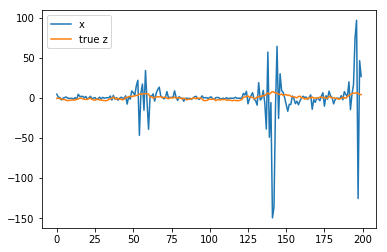

In [4]:
plt.plot(x.numpy(), label='x')
plt.plot(z_true.numpy(), label='true z')
plt.legend();

In [5]:
p = StochasticVolatilityModel(
    a=torch.tensor(1.), b=torch.tensor(0.), c=torch.tensor(0.95))
q = AR1Proposal(μ=0., ρ=0.5)
log_phatN, Z, resampled = simulate_FIVO(x, p, q, N=10, resample=True)
print(f'p = {p}')
print(f'q = {q}')

p = Stochastic volatility model
x_t = exp(1.00 * z_t/2) ε_t
z_t = 0.00 + 0.95 * z_{t-1} + ν_t
ε_t ~ Ν(0,1)
ν_t ~ Ν(0,1)
q = AR(1) proposals
z_t = 0.00 + 0.50 * z_{t-1} + η_t
η_t ~ Ν(0,1)


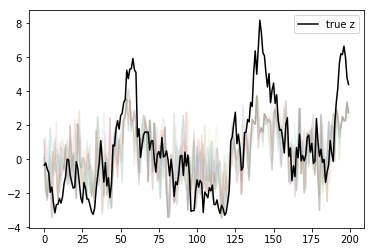

In [6]:
plt.plot(Z.numpy(), alpha=0.1);
plt.plot(z_true.numpy(), color='black', label='true z')
plt.legend();

In [7]:
torch.manual_seed(123)
# stochastic optimization
θ = torch.zeros((3,), requires_grad=True)
φ = torch.zeros((2,), requires_grad=True)
fivos = []
opt = torch.optim.Adadelta([θ])
for i in range(2**12):
    opt.zero_grad()
    p = StochasticVolatilityModel(a=θ[0], b=θ[1], c=θ[2])
    #q = AR1Proposal(μ=φ[0], ρ=φ[1])
    # hard code q until I can work out what the bug is
    q = AR1Proposal(μ=torch.tensor(0.), ρ=torch.tensor(0.95))
    log_phatN, Z, resampled = simulate_FIVO(
        x, p, q, N=10, resample=True, rewrite_history=True)
    loss = -log_phatN
    loss.backward()
    fivos.append(log_phatN.detach())
    if not i&(i-1):
        print(f'{i:8d}. FIVO = {log_phatN.data:6.2f}')
    opt.step()
else:
    print('Maximum iterations reached')
print(f'{i:8d}. FIVO = {log_phatN.data:6.2f}')

print(f'φ = {φ}')
print(f'θ = {θ}')

       0. FIVO = -1398.82
       1. FIVO = -1273.23
       2. FIVO = -1633.81
       4. FIVO = -1280.80
       8. FIVO = -1272.55
      16. FIVO = -1200.13
      32. FIVO = -1134.60
      64. FIVO = -943.00
     128. FIVO = -692.76
     256. FIVO = -500.47
     512. FIVO = -511.08
    1024. FIVO = -478.77
    2048. FIVO = -474.21
Maximum iterations reached
    4095. FIVO = -519.40
φ = tensor([0., 0.], requires_grad=True)
θ = tensor([ 3.4993, -0.0578,  0.9856], requires_grad=True)


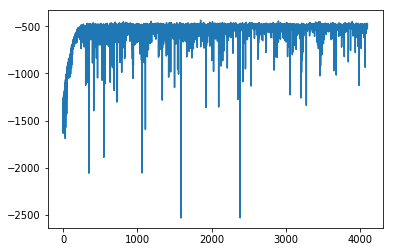

In [11]:
plt.plot(fivos);